<a href="https://colab.research.google.com/github/NushratRia/Big-Data/blob/main/Lab3_PySpark_K_means_Clustering_on_seeds_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wheat Type:  1 Kama, 2 Rosa, and 3 Canadian

In [ ]:
!pip install PySpark

In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.4.1


In [ ]:
#Loading the data
dataset = spark.read.csv("/content/seeds_dataset.csv",header=True,inferSchema=True)

#show the data in the above file using the below command
dataset.show(5)

+-----+---------+-----------+-----------------+---------------+---------------------+-----------------------+----------+
| Area|Perimeter|Compactness|Length_of_ kernel|Width_of_kernel|Asymmetry_coefficient|Length_of_kernel_groove|Wheat_Type|
+-----+---------+-----------+-----------------+---------------+---------------------+-----------------------+----------+
|15.26|    14.84|      0.871|            5.763|          3.312|                2.221|                   5.22|         1|
|14.88|    14.57|     0.8811|            5.554|          3.333|                1.018|                  4.956|         1|
|14.29|    14.09|      0.905|            5.291|          3.337|                2.699|                  4.825|         1|
|13.84|    13.94|     0.8955|            5.324|          3.379|                2.259|                  4.805|         1|
|16.14|    14.99|     0.9034|            5.658|          3.562|                1.355|                  5.175|         1|
+-----+---------+-----------+---

In [ ]:
#Print schema
dataset.printSchema()

root
 |-- Area: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- Length_of_ kernel: double (nullable = true)
 |-- Width_of_kernel: double (nullable = true)
 |-- Asymmetry_coefficient: double (nullable = true)
 |-- Length_of_kernel_groove: double (nullable = true)
 |-- Wheat_Type: integer (nullable = true)



Format the data using Vector Assembler into vectors which will be used as “features”

In [ ]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = ['Area', 'Perimeter', 'Compactness', 'Length_of_ kernel', 'Width_of_kernel', 'Asymmetry_coefficient', 'Length_of_kernel_groove'],
                                outputCol='features')

final_data = vec_assembler.transform(dataset)
final_data.select('features', 'Wheat_Type').show()

+--------------------+----------+
|            features|Wheat_Type|
+--------------------+----------+
|[15.26,14.84,0.87...|         1|
|[14.88,14.57,0.88...|         1|
|[14.29,14.09,0.90...|         1|
|[13.84,13.94,0.89...|         1|
|[16.14,14.99,0.90...|         1|
|[14.38,14.21,0.89...|         1|
|[14.69,14.49,0.87...|         1|
|[14.11,14.1,0.891...|         1|
|[16.63,15.46,0.87...|         1|
|[16.44,15.25,0.88...|         1|
|[15.26,14.85,0.86...|         1|
|[14.03,14.16,0.87...|         1|
|[13.89,14.02,0.88...|         1|
|[13.78,14.06,0.87...|         1|
|[13.74,14.05,0.87...|         1|
|[14.59,14.28,0.89...|         1|
|[13.99,13.83,0.91...|         1|
|[15.69,14.75,0.90...|         1|
|[14.7,14.21,0.915...|         1|
|[12.72,13.57,0.86...|         1|
+--------------------+----------+
only showing top 20 rows



 Scaling the data ( to deal with the curse of dimensionality)

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[5.24452795332028...|
|[5.11393027165175...|
|[4.91116018695588...|
|[4.75650503761158...|
|[5.54696468981581...|
+--------------------+
only showing top 5 rows



In [ ]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score) #measures how close each point in one cluster is to points in the neighboring clusters

Silhouette Score for k = 2 is 0.6343905763864178
Silhouette Score for k = 3 is 0.5127320298188953
Silhouette Score for k = 4 is 0.6270415388938357
Silhouette Score for k = 5 is 0.3876685758988001
Silhouette Score for k = 6 is 0.5553489135130518
Silhouette Score for k = 7 is 0.4905785052027749
Silhouette Score for k = 8 is 0.4298676318762632
Silhouette Score for k = 9 is 0.41746519261780446


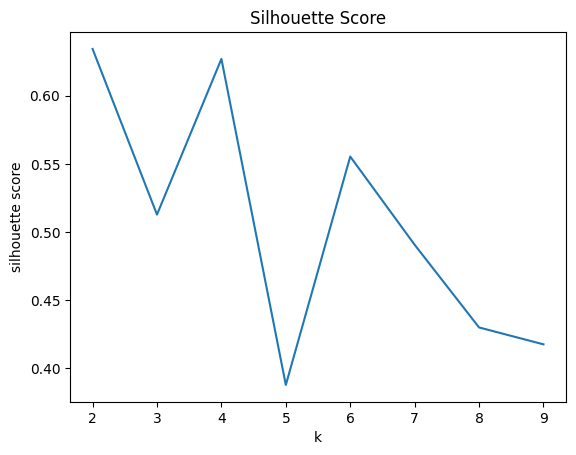

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

Train the Model

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [ ]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 6.32636687 12.38115343  8.89078016 11.20986748  9.06617324  2.40935966
 11.85640551]
[ 4.94722074 10.97038167  9.06145399  9.88842602  8.07727636  1.70304126
  9.9731889 ]
[ 4.10268066 10.15997921  8.56394192  9.50702679  7.05235376  3.21191061
 10.01039164]


In [ ]:
predictions.select('Area', 'Wheat_Type', 'prediction').show()

+-----+----------+----------+
| Area|Wheat_Type|prediction|
+-----+----------+----------+
|15.26|         1|         1|
|14.88|         1|         1|
|14.29|         1|         1|
|13.84|         1|         1|
|16.14|         1|         1|
|14.38|         1|         1|
|14.69|         1|         1|
|14.11|         1|         1|
|16.63|         1|         0|
|16.44|         1|         1|
|15.26|         1|         1|
|14.03|         1|         1|
|13.89|         1|         1|
|13.78|         1|         1|
|13.74|         1|         1|
|14.59|         1|         1|
|13.99|         1|         2|
|15.69|         1|         1|
| 14.7|         1|         1|
|12.72|         1|         2|
+-----+----------+----------+
only showing top 20 rows



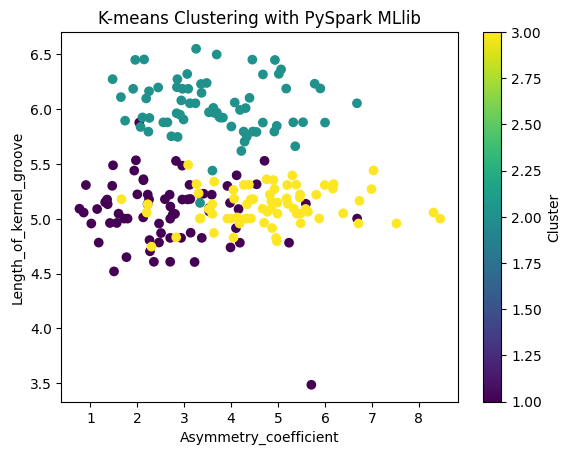

In [ ]:
# Converting to Pandas DataFrame
predictions_pd = predictions.toPandas()

# Visualizing the results
plt.scatter(predictions_pd["Asymmetry_coefficient"], predictions_pd["Length_of_kernel_groove"], c= predictions_pd["Wheat_Type"])
plt.xlabel("Asymmetry_coefficient")
plt.ylabel("Length_of_kernel_groove")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [ ]:
#End Session
spark.stop()